In [1]:
import matplotlib as mpl
import matplotlib.pylab as plt


In [2]:
import requests
import healpy
import io
import astropy.io.fits as fits

f = fits.open(io.BytesIO(requests.get("https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/triggers/2021/bn211223350/quicklook/glg_healpix_all_bn211223350.fit").content))


In [3]:
import healtics

In [4]:
T0_isot = "2021-12-23T08:23:22"
import integralclient as ic

T0_dict = ic.converttime('UTC', T0_isot, 'ANY')
print(T0_dict)
ic.converttime('SCWID', T0_dict['SCWID'], 'UTC')



failed to get AUTH with env due to: 'K8S_SECRET_INTEGRAL_CLIENT_SECRET'
got AUTH with homefile for integral-limited


/home/savchenk/.pyenv/versions/3.9.6/lib/python3.9/site-packages/papermill/iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem
/home/savchenk/.pyenv/versions/3.9.6/lib/python3.9/site-packages/scrapbook/__init__.py:8: FutureWarning: 'nteract-scrapbook' package has been renamed to `scrapbook`. No new releases are going out for this old package name.
  warnings.warn("'nteract-scrapbook' package has been renamed to `scrapbook`. No new releases are going out for this old package name.", FutureWarning)
2021-12-23 12:34:10 savchenk-NG-VN7-793G-79EG root[2417663] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/UTC/2021-12-23T08:23:22/ANY
2021-12-23 12:34:10 savchenk-NG-VN7-793G-79EG root[2417663] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/SCWID/244900120010/UTC


{'IJD': '8027.350360925926', 'OBT': '9085194276108061', 'OBTFITS': '    2    74381848   718621 :    32 18159 41354 63261', 'REVNUM': '2449', 'SCWID': '244900120010', 'UTC': '2021-12-23T08:23:22', 'YYYYDDDHH': '202135708'}


'2021-12-23T07:28:15.312 2021-12-23T08:26:15.314'

2021-12-23 13:24:58 savchenk-NG-VN7-793G-79EG healpy[2417663] INFO NSIDE = 128
2021-12-23 13:24:58 savchenk-NG-VN7-793G-79EG healpy[2417663] INFO ORDERING = NESTED in fits file
2021-12-23 13:24:58 savchenk-NG-VN7-793G-79EG healpy[2417663] INFO INDXSCHM = IMPLICIT
2021-12-23 13:24:58 savchenk-NG-VN7-793G-79EG healpy[2417663] INFO Ordering converted to RING


to overplot 1
to overplot [[]]


(<Figure size 510.236x340.158 with 2 Axes>,
 <module 'matplotlib.pylab' from '/home/savchenk/.pyenv/versions/3.9.6/lib/python3.9/site-packages/matplotlib/pylab.py'>)

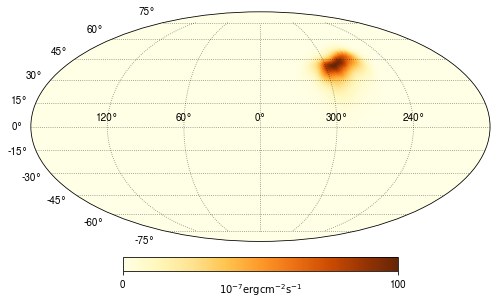

In [84]:
import numpy as np

mp = healpy.read_map(f)

#healpy.mollview(mp, lonlat=True)

indices = np.argsort(mp)
region = np.empty(mp.shape)
region[indices] = 100 * np.cumsum(mp[indices])


healtics.plot_with_ticks(region, overplot=[[]])



In [47]:
import oda_api.api
import oda_api.token
oda = oda_api.api.DispatcherAPI()

oda_image_prod = oda.get_product(
    'isgri_image', 
    'isgri', 
    scw_list=[T0_dict['SCWID']+".000"], 
    integral_data_rights="all-private", 
    token=oda_api.token.discover_token())

2021-12-23 13:11:15 savchenk-NG-VN7-793G-79EG oda_api.token[2417663] INFO found token in environment variable ODA_TOKEN your token payload: {
    "email": "Volodymyr.Savchenko@unige.ch",
    "exp": 1642784885.2514007,
    "msdone": false,
    "mssub": false,
    "name": "sitamin",
    "roles": "authenticated user, administrator, content manager, general, integral-private-qla, magic, unige-hpc-full, public-pool-hpc, antares",
    "sub": "Volodymyr.Savchenko@unige.ch"
}
2021-12-23 13:11:15 savchenk-NG-VN7-793G-79EG oda_api.token[2417663] INFO token expires in 700.9 h
2021-12-23 13:11:15 savchenk-NG-VN7-793G-79EG oda_api.advice[2417663] WARNING please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
2021-

In [48]:
oda_image_prod.as_list()
catalog = oda_image_prod.dispatcher_catalog_1.table

In [106]:
import importlib
import ddaclient
import hashlib

importlib.reload(ddaclient)

hashstring = lambda x:hashlib.sha224(x.encode()).hexdigest()[:8]

ddac = ddaclient.RemoteDDA("http://dda.staging.internal.odahub.io", 
                           "/mnt/sshfs/cdcihn/unsaved/astro/savchenk/data/reduced/ddcache")

modules = ["git://ddosa/staging-1-3", "git://findic/staging-1-3-icversion",
           "git://ddosa11/staging-1-3", "git://osa11p1/master",'git://ddosa_delegate/staging-1-3']
#ddac.poke()

cat = ("SourceCatalog", 
           {
            "autoversion": True, 
            "catalog": [
                #{"NAME":"SGR 1935+2154", "RA": 293.73200 , "DEC":  21.89672}
            ]
           }
      )

def oda_image(t0_geo, dt1, dt2):
    t0_geo_ijd = float(ic.converttime("ANY", t0_geo, "IJD"))
    t0_geo_isot = ic.converttime("ANY", t0_geo, "UTC")
    
    barycorr = 0#ic.get_sc(t0_geo_isot, ra=source_coord.ra.deg, dec=source_coord.dec.deg)['barytime']
    
    print(barycorr)
    
    t0_int_ijd = t0_geo_ijd - barycorr/24./3600.
    
    t1_utc = ic.converttime("IJD", 
                               t0_int_ijd + dt1/24/3600, 
                               "UTC")

    t2_utc = ic.converttime("IJD", 
                            t0_int_ijd + dt2/24/3600, 
                            "UTC")

    scw=ic.converttime("IJD", t0_int_ijd, "SCWID")
    
    r = ddac.query('ii_skyimage', 
                modules=modules,
                assume=[
                   'ddosa.ScWData(input_scwid="{}.000")'.format(scw),
                   'ddosa.ibis_gti(input_usergti=ddosa.gti_user)',
                   'ddosa11.BinEventsImage(use_NoisyDetFlag=0)',
                   'ddosa.UserGTI(use_gti=["{}", "{}"], use_version="{}")'.format(t1_utc,t2_utc, hashstring(t1_utc+t2_utc)),                
                   'ddosa.ICRoot(use_ic_root_version="beta")'
               ],
               prompt_delegate=True,
               #inject=[cat],
               #callback="http://nourl?sessionid=testsession&jobid=testjob"
            )
    
    return r


short_image = oda_image(T0_isot,          
          -100, 100
          )

2021-12-23 13:36:36 savchenk-NG-VN7-793G-79EG root[2417663] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/ANY/2021-12-23T08:23:22/IJD
2021-12-23 13:36:36 savchenk-NG-VN7-793G-79EG root[2417663] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/ANY/2021-12-23T08:23:22/UTC
2021-12-23 13:36:36 savchenk-NG-VN7-793G-79EG root[2417663] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/IJD/8027.3492035185181521/UTC
2021-12-23 13:36:36 savchenk-NG-VN7-793G-79EG root[2417663] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/IJD/8027.3515183333338427/UTC


0


2021-12-23 13:36:36 savchenk-NG-VN7-793G-79EG root[2417663] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/IJD/8027.3503609259259974/SCWID
2021-12-23 13:36:36 savchenk-NG-VN7-793G-79EG ddaclient[2417663] INFO (('modules', 'git://ddosa/staging-1-3,git://findic/staging-1-3-icversion,git://ddosa11/staging-1-3,git://osa11p1/master,git://ddosa_delegate/staging-1-3'), {})
2021-12-23 13:36:36 savchenk-NG-VN7-793G-79EG ddaclient[2417663] INFO (('assume', 'ddosa.ScWData(input_scwid="244900120010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2021-12-23T08:21:41.999", "2021-12-23T08:25:02.000"], use_version="ca2a5b3e"),ddosa.ICRoot(use_ic_root_version="beta")'), {})
2021-12-23 13:36:36 savchenk-NG-VN7-793G-79EG ddaclient[2417663] INFO (('service url:', 'http://dda.staging.internal.odahub.io'), {})
2021-12-23 13:36:36 savchenk-NG-VN7-793G-79EG ddaclient[2417663] INFO (('targ

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
2021-12-23 13:38:44 savchenk-NG-VN7-793G-79EG astropy[2417663] WARNING FITSFixedWarning: RADECSYS= 'FK5 ' / Stellar reference frame 
the RADECSYS keyword is deprecated, use RADESYSa.
2021-12-23 13:38:44 savchenk-NG-VN7-793G-79EG astropy[2417663] WARNING FITSFixedWarning: 'datfix' made the change 'Set DATEREF to '2000-01-01' from MJDREF'.
2021-12-23 13:38:45 savchenk-NG-VN7-793G-79EG root[2417663] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/IJD/8027.31208908068038/UTC
2021-12-23 13:38:45 savchenk-NG-VN7-793G-79EG root[2417663] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/IJD/8027.3523668840198297/UTC


Text(0.5, 1.0, '2021-12-23 07:28:15 - 08:26:15')

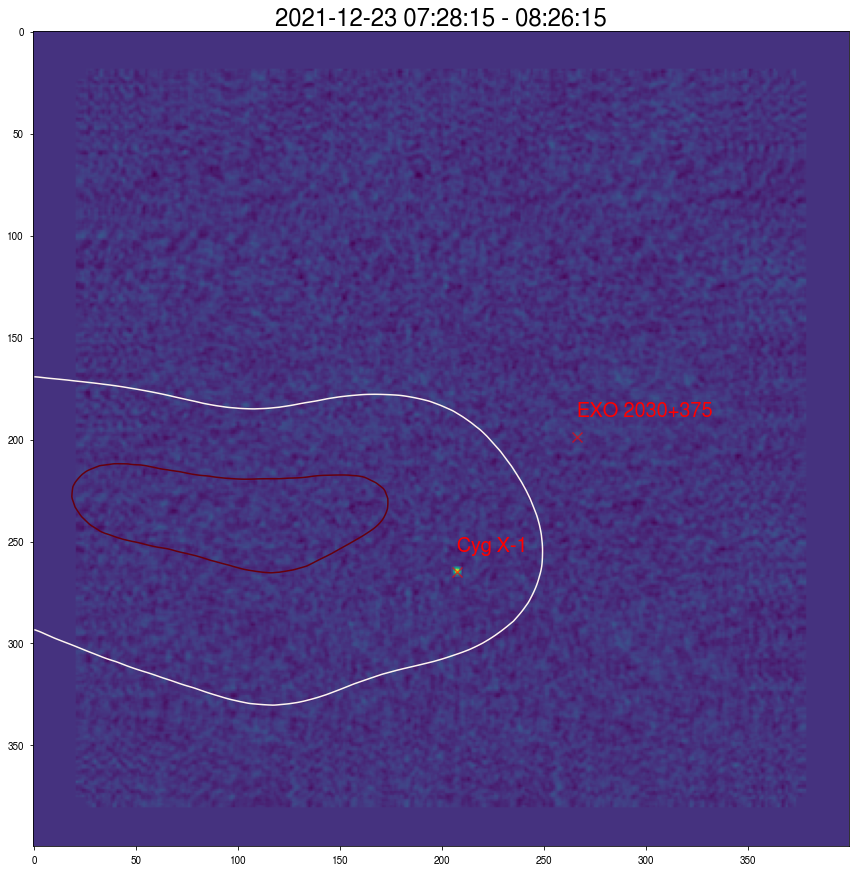

In [114]:


from astropy.wcs import WCS
import numpy as np

isgri_image = fits.open(short_image.skyima) #T0_dict['SCWID']

isgri_image_wcs = WCS(isgri_image[4])



from matplotlib import cm

px = np.arange(region.shape[0])
ra, dec = healpy.pix2ang(healpy.npix2nside(px.shape[0]), px, lonlat=True)

i, j = np.meshgrid(np.arange(400), np.arange(400))

ra, dec = isgri_image_wcs.wcs_pix2world(i, j, 0)

isgri_region = healpy.get_interp_val(region, ra, dec, lonlat=True)

plt.figure(figsize=(15,15))

plt.imshow(isgri_image[4].data)
plt.contour(isgri_region, levels=[50, 90], cmap=cm.Reds)

for l in catalog:
    (o_i, o_j), = isgri_image_wcs.all_world2pix([[l['ra'], l['dec']]], 0)
    if o_i>0 and o_i<400 and o_j>0 and o_j<400:        
        plt.text(o_i, o_j - 10, l['src_names'], size=20, color='r')
        plt.scatter(o_i, o_j, color='r', marker='x', alpha=0.6, s=100)
        # break   
    else:
        print('skip', l)

plt.title(f"{ic.converttime('IJD', isgri_image[4].header['TSTART'], 'UTC').replace('T', ' ')[:-4]}"
          f" - {ic.converttime('IJD', isgri_image[4].header['TSTOP'], 'UTC').split('T')[1][:-4]}"
, size=24)

2021-12-23 13:39:37 savchenk-NG-VN7-793G-79EG healpy[2417663] WARNING 0.0 180.0 -180.0 180.0
2021-12-23 13:39:37 savchenk-NG-VN7-793G-79EG healpy[2417663] INFO The interval between parallels is 30 deg -0.00'.
2021-12-23 13:39:37 savchenk-NG-VN7-793G-79EG healpy[2417663] INFO The interval between meridians is 30 deg -0.00'.


Text(0.5, 1.0, '')

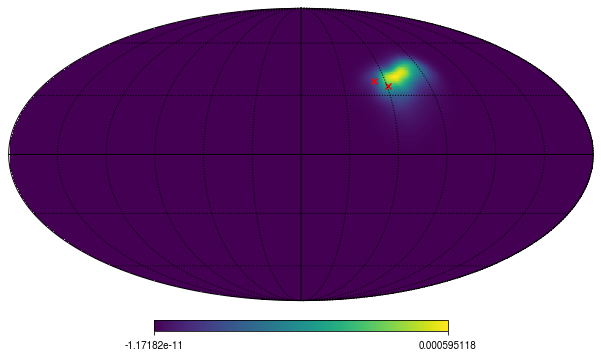

In [118]:
healpy.mollview(mp)
healpy.graticule()


for l in catalog:
    # (o_i, o_j), = isgri_image_wcs.all_world2pix([[l['ra'], l['dec']]], 0)
    # if o_i>0 and o_i<400 and o_j>0 and o_j<400:        
    #     plt.text(o_i, o_j - 10, l['src_names'], size=20, color='r')
        # plt.scatter(o_i, o_j, color='r', marker='x', alpha=0.6, s=100)
    healpy.projscatter(
        l['ra'],
        l['dec'],
        lonlat=True,
        c='r',
        marker='x'
    )

plt.title("")